In [1]:
%matplotlib notebook
import matplotlib.pyplot as pl
from astropy.io import fits
from ngmix.medsreaders import NGMixMEDS
import numpy as np
import galsim

import sys
sys.path.insert(0,'/Users/secco/Documents/projects/delve_shear/delve_cs_test/code/newish_metacal/tests')
sys.path.insert(0,'/Users/secco/Documents/projects/delve_shear/delve_cs_test/code/newish_metacal')
sys.path.insert(0,'/Users/secco/Documents/projects/delve_shear/delve_cs_test/code/newish_metacal/metacal')

import test_metacal

medsname = '/Users/secco/Documents/projects/delve_shear/delve_cs_test/data/TESTBED_DES0954+0252_r4918p01_i_meds-DECADE.fits.fz'

In [3]:
#verify that things are working:
test_metacal.run_single_sim_pair(seed=42)

(array([(26., 26., 0, [-1.16255731e-06, -1.71354727e-06], 0.30380967, 36, 699937.96971246, 0., [ 1.51535575e-01, -1.51535301e-01,  1.84580775e-02,  1.74505561e-06,  3.64875020e-01,  9.49235198e-01], [[ 4.46386839e-07,  1.52270434e-11,  1.38785289e-11, -4.27600168e-12, -1.74866095e-11, -1.62749180e-11], [ 1.52270434e-11,  4.64552491e-07, -3.37799058e-11, -1.36067695e-10, -7.03049905e-12, -1.31471931e-11], [ 1.38785289e-11, -3.37799058e-11,  2.33206655e-06,  6.28341809e-11,  4.53470956e-09, -2.05086056e-08], [-4.27600168e-12, -1.36067695e-10,  6.28341809e-11,  2.33063142e-06, -1.48605255e-10, -1.07375945e-11], [-1.74866095e-11, -7.03049905e-12,  4.53470956e-09, -1.48605255e-10,  1.24109832e-06,  8.64674345e-07], [-1.62749180e-11, -1.31471931e-11, -2.05086056e-08, -1.07375945e-11,  8.64674345e-07,  1.20536719e-06]], [1.84580775e-02, 1.74505561e-06], [[2.33206655e-06, 6.28341809e-11], [6.28341809e-11, 2.33063142e-06]], 0.36487502, 0.00111405, 1.2009987, [0.9492352], [[0.]], [0.00109789], 4

# Write simple stuff into the MEDS file

Before creating the simulations, let's get the metadata (like image size, jacobians and etc) from the MEDS file

In [6]:
m = fits.open(medsname)
m.info()
m[1].header

Filename: /Users/secco/Documents/projects/delve_shear/delve_cs_test/data/TESTBED_DES0954+0252_r4918p01_i_meds-DECADE.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1  object_data    1 BinTableHDU     77   28586R x 33C   [K, K, D, D, K, 11K, 11K, 11D, 11D, 11K, 11K, 11D, 11D, 11D, 11D, 11D, 11D, K, J, E, E, E, E, E, E, E, D, D, 11J, 11J, 11D, 11D, 11K]   
  2  image_info    1 BinTableHDU     43   44R x 16C   [45A, 4A, 45A, 4A, 45A, 4A, 45A, 4A, 45A, 4A, 38A, K, E, E, D, 2338A]   
  3  metadata      1 BinTableHDU     35   1R x 12C   [D, 10A, 4A, 1358A, 8A, 1A, 12A, 6A, 5A, 8A, 5A, 5A]   
  4  image_cutouts    1 CompImageHDU     17   (333934592,)   float32   
  5  weight_cutouts    1 CompImageHDU     17   (333934592,)   float32   
  6  seg_cutouts    1 CompImageHDU     13   (333934592,)   int32   
  7  bmask_cutouts    1 CompImageHDU     13   (333934592,)   int32   
  8  psf           1 CompImageHDU     17   (3441

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                 1504 / width of table in bytes                        
NAXIS2  =                28586 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   33 / number of fields in each row                   
TTYPE1  = 'id      '           / label for field   1                            
TFORM1  = 'K       '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'box_size'           / label for field   2                            
TFORM2  = 'K       '           / data format of field: 8-byte INTEGER           
TTYPE3  = 'ra      '        

Suppose we want to the following for the object at index 300: the image size, image start/end row and center,  psf size and start/end row and jacobian elements 'dudrow', 'dudcol', 'dvdrow', 'dvdcol' 

In [4]:
obj_ind=300

In [5]:
box_size = m[1].data['box_size'][obj_ind]
ncutout = m[1].data['ncutout'][obj_ind]
start_row = m[1].data['start_row'][obj_ind]
start_row_next = m[1].data['start_row'][obj_ind+1]

cutout_row = m[1].data['cutout_row'][obj_ind]
cutout_col = m[1].data['cutout_col'][obj_ind]
orig_start_row = m[1].data['orig_start_row'][obj_ind]

psf_row = m[1].data['psf_row_size'][obj_ind]
psf_col = m[1].data['psf_col_size'][obj_ind]
psf_start_row = m[1].data['psf_start_row'][obj_ind]


print('Object at index',obj_ind,'has N=',ncutout,'cutouts (single epochs)')
print('Its box size is',box_size,', so the start_row for each cutout of this object should be',box_size,'x',box_size,
      r'away from the next cutout, and N x',box_size,'x',box_size,'from the next object')
print("Let's see: start_row =",start_row,'(ignore -9999)')
print("And the start_row for the next object is",start_row_next)

print('\n\n')

print("No idea what orig_start_row =",orig_start_row,'and some of the other keys are,')

print('\n\n')

print('cutout_row =',cutout_row,'should be the row of the center of the image in the box coordinates')
print('and similar for cutout_col =',cutout_col)

print('\n\n')

print('The PSF row size is = ',psf_row)
print('and the PSF col size is = ',psf_col)
print('and naturally, since it seems the psf boxes can have differente sizes, they have a separate start_row:',psf_start_row)

Object at index 300 has N= 2 cutouts (single epochs)
Its box size is 32 , so the start_row for each cutout of this object should be 32 x 32 away from the next cutout, and N x 32 x 32 from the next object
Let's see: start_row = [1796096 1797120   -9999   -9999   -9999   -9999   -9999   -9999   -9999
   -9999   -9999] (ignore -9999)
And the start_row for the next object is [1798144 1799168   -9999   -9999   -9999   -9999   -9999   -9999   -9999
   -9999   -9999]



No idea what orig_start_row = [  222   726 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999 -9999] and some of the other keys are,



cutout_row = [   15.71350098    15.11155049 -9999.         -9999.
 -9999.         -9999.         -9999.         -9999.
 -9999.         -9999.         -9999.        ] should be the row of the center of the image in the box coordinates
and similar for cutout_col = [   15.01660156    15.24393696 -9999.         -9999.
 -9999.         -9999.         -9999.         -9999.
 -9999.         -9999.        

Try to plot an image by accessing its start row in the `image_cutouts` extension of the MEDS file

<IPython.core.display.Javascript object>


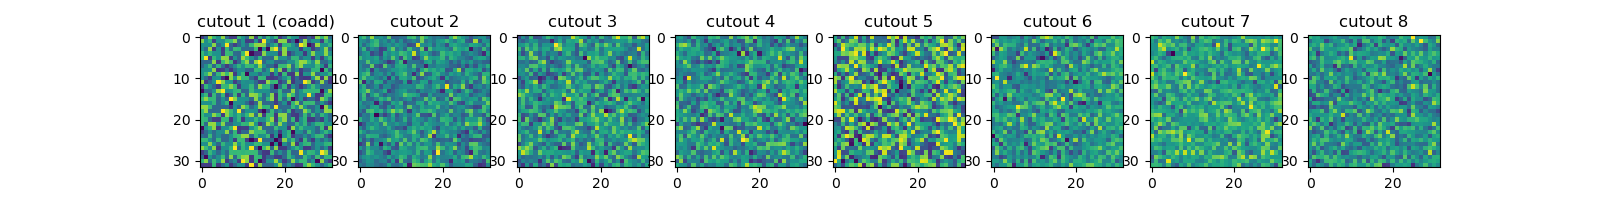

In [6]:
obj_ind=23001
Ncutouts = m[1].data['ncutout'][obj_ind]
Nrows = 1
Ncols = Ncutouts
pl.figure(figsize=(Ncutouts*2, Nrows*2))
for i in np.arange(Ncutouts)+1:
    pl.subplot(Nrows,Ncutouts,i)
    start_row = m[1].data['start_row'][obj_ind][i-1] #i=0 is the coadd
    box_size = m[1].data['box_size'][obj_ind]
    pl.imshow(m['image_cutouts'].data[start_row:(start_row+box_size**2)].reshape(box_size,box_size))
    if i==1:
        pl.title('cutout %d (coadd)'%i)
    else:
        pl.title('cutout %d'%i)
    

Now try to re-write one cutout of the file. Once this is done, we can go ahead and start creating image sims that will replace the meds file cutouts.

<IPython.core.display.Javascript object>


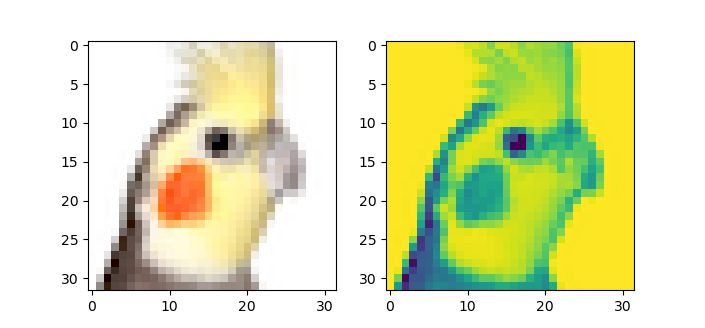

In [7]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
b = pl.imread('/Users/secco/Desktop/bird.png')
b_gray = rgb2gray(b)*100 #need to multiply by a large number otherwise the compression destroys the image... kinda weird
pl.subplot(121)
pl.imshow(b)
pl.subplot(122)
pl.imshow(b_gray)

Let's re-write cutout number 0 (the coadd) of the object 1500:

(the image above assumed I already knew the boxsize is 32...)

In [8]:
cutout_number=0
box_size=32
obj_id=1500
start_row = m[1].data['start_row'][obj_ind][cutout_number]
end_row = start_row + box_size**2
m['image_cutouts'].data[start_row:end_row] = b_gray.ravel() #turn the grayscale image into a 1D array of size 32^2

Now write this file to disk with the applied changes

In [29]:
m.writeto('/Users/secco/Documents/projects/delve_shear/delve_cs_test/data/out_test.fits',overwrite=True)
#this will re-write the entire ~1Gb file

Open the file again and see if the modification is there

<IPython.core.display.Javascript object>


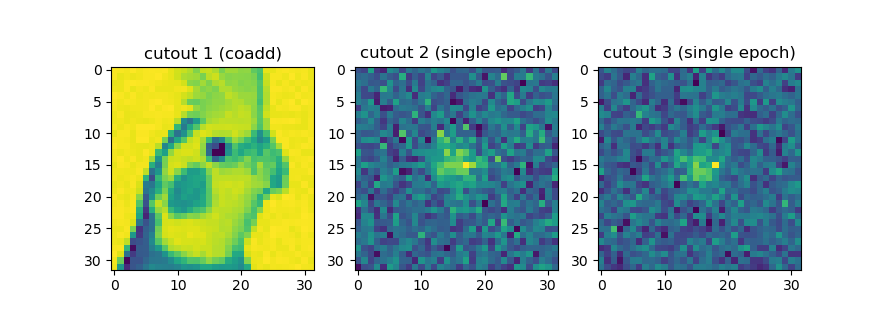

[104.424324 103.948746 103.141716 ... 104.65387  103.20363  102.42784 ]
[ -76.05877   -111.43845    192.4417    ...  197.5791     152.6851
   -3.9927444]
[ -55.855915  127.08415    39.81325  ...   19.456406 -125.96143
   25.262407]


In [9]:
m = fits.open('/Users/secco/Documents/projects/delve_shear/delve_cs_test/data/out_test.fits')

obj_ind=1500
Ncutouts = m[1].data['ncutout'][obj_ind]
Nrows = 1
Ncols = Ncutouts
pl.figure(figsize=(Ncutouts*2, Nrows*2))
for i in np.arange(Ncutouts)+1:
    pl.subplot(Nrows,Ncutouts,i)
    start_row = m[1].data['start_row'][obj_ind][i-1] #i=0 is the coadd
    box_size = m[1].data['box_size'][obj_ind]
    pl.imshow(m['image_cutouts'].data[start_row:(start_row+box_size**2)].reshape(box_size,box_size))
    if i==1:
        pl.title('cutout %d (coadd)'%i)
    else:
        pl.title('cutout %d (single epoch)'%i)
        
    print(m['image_cutouts'].data[start_row:(start_row+box_size**2)])
    

OK so things are working, even though the compression vs. decompression of the file is causing some issues

Let's simulate some galaxies now

# Create simple image sims and write them up in the MEDS file

`test_metacal.py` has the basic functions to create a simulation (the func called `make_sim`), let's  copy that down here and start modifying it

In [ ]:
'''
def make_sim(*, seed, g1, g2):
    rng = np.random.RandomState(seed=seed)

    gal = galsim.Exponential(half_light_radius=0.5).shear(g1=g1, g2=g2)
    psf = galsim.Gaussian(fwhm=0.9)
    obj = galsim.Convolve([gal, psf])
    dim = 53
    cen = (dim-1)/2
    dither = rng.uniform(size=2, low=-0.5, high=0.5)
    scale = 0.263

    im = obj.drawImage(nx=53, ny=53, offset=dither, scale=scale).array
    nse = np.sqrt(np.sum(im**2)) / 1e6
    im += rng.normal(size=im.shape, scale=nse)

    psf_im = psf.drawImage(nx=53, ny=53, scale=scale).array

    jac = ngmix.DiagonalJacobian(
        scale=scale, row=cen+dither[0], col=cen+dither[1]
    )
    psf_jac = ngmix.DiagonalJacobian(
        scale=scale, row=cen, col=cen
    )

    obs = ngmix.Observation(
        image=im,
        weight=np.ones_like(im) / nse**2,
        jacobian=jac,
        bmask=np.zeros_like(im, dtype=np.int32),
        psf=ngmix.Observation(
            image=psf_im,
            jacobian=psf_jac,
        ),
        meta={"orig_row": cen, "orig_col": cen},
    )
    return ngmix.observation.get_mb_obs(obs)
'''

Here's what I'll try to do:

In [31]:
def make_sim_one_cutout(*, seed, g1, g2, open_meds, obj_ind, cutout):
    m = open_meds        
    #rng = np.random.RandomState(seed=seed)
    gal = galsim.Exponential(half_light_radius=0.5).shear(g1=g1, g2=g2) #let's do sheared exponentials again
    
    #fwhm=rng.uniform(low=0.8,high=1.5) #will use a random FWHM for each sim just because
    fwhm=np.random.uniform(low=0.8,high=1.5)
    psf = galsim.Gaussian(fwhm=fwhm) 
    obj = galsim.Convolve([gal, psf]) 
    
    dim = m[1].data['box_size'][obj_ind] #size of the image box
    
    cutout_row = m[1].data['cutout_row'][obj_ind][cutout]
    cutout_col = m[1].data['cutout_col'][obj_ind][cutout]
    cen=[cutout_row,cutout_col] #getting the image center from the meds file
    dither = np.random.uniform(size=2, low=-0.5, high=0.5)
    scale = 0.263 #the size of a DECam pixel in arcsec on the sky 

    flux = m[1].data['flux'][obj_ind]
    im = obj.drawImage(nx=dim, ny=dim, offset=dither, scale=scale, center=cen).array * flux #multiplying by flux here, is that what I really want?
    
    im_start_row = m[1].data['start_row'][obj_ind][cutout]
    im_end_row = im_start_row + dim**2
    weight=m[5].data[im_start_row:im_end_row].reshape(dim,dim) #get the weight of each cutout, will use this to add noise to the simulated image
    nse=np.sqrt(1.0/weight)
    #im += rng.normal(size=im.shape, scale=nse)
    im += np.random.normal(size=im.shape, scale=nse)

 
    psf_row = m[1].data['psf_row_size'][obj_ind][cutout] #size of the PSF (rows) for each cutout
    psf_col = m[1].data['psf_col_size'][obj_ind][cutout] #size of the PSF (cols) for each cutout
    assert psf_row==psf_col, "PSF is not a square, which they say is not cool"
    
    psf_start_row = m[1].data['psf_start_row'][obj_ind][cutout]
    psf_end_row = psf_start_row + psf_row*psf_col
    psf_im = psf.drawImage(nx=psf_row, ny=psf_col, scale=scale).array
    
    return im.ravel(), psf_im.ravel(), im_start_row, im_end_row, psf_start_row, psf_end_row
    #To do: stop ignoring jacobians and bmask


def replace_all_cutouts_by_sims(input_medsname, output_medsname,verbose=False):
    m = fits.open(input_medsname) #opens the input file
    Nobjects = m[1].header['NAXIS2'] #gets number of objects (rows) in the file
    for i_obj in range(Nobjects): #loops over objects in the file
        Ncutout = m[1].data['ncutout'][i_obj] 
        if verbose and i_obj%1000==0: print("Object %d has %d cutouts to be replaced"%(i_obj,Ncutout))
        for j_cut in range(Ncutout): #loops over cutout in each object in the file
            im, psf, im_start, im_end, psf_start, psf_end = make_sim_one_cutout(seed=10, g1=0.02, g2=0.00, 
                                                                                    open_meds=m, obj_ind=i_obj, cutout=j_cut)
                
            m['image_cutouts'].data[im_start : im_end] = im
            m['psf'].data[psf_start : psf_end] = psf
    #the end:
    m.writeto(output_medsname,overwrite=True)
    m.close()

Try to plot one of these simualted galaxies \& PSF

Here's the original image and its PSF for an example object:

<IPython.core.display.Javascript object>


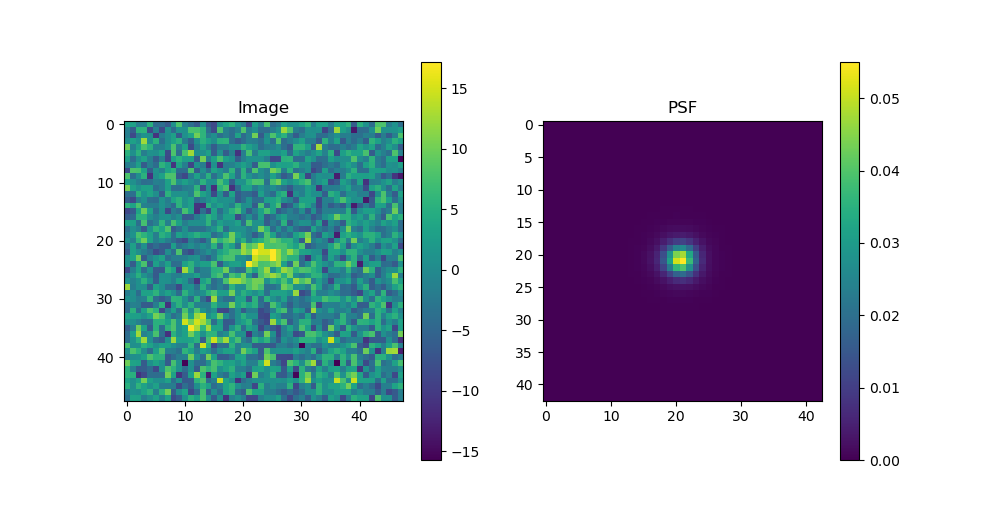

In [37]:
obj_index = 4000

pl.figure()
pl.subplot(121)
pl.title('Image')
start_row = m[1].data['start_row'][obj_index][0] #0-th cutout
box_size = m[1].data['box_size'][obj_index]
pl.imshow(m['image_cutouts'].data[start_row:(start_row+box_size**2)].reshape(box_size,box_size))
pl.colorbar()

pl.subplot(122)
pl.title('PSF')
psf_start_row = m[1].data['psf_start_row'][obj_index][0]
psf_row = m[1].data['psf_row_size'][obj_index][0]
psf_col = m[1].data['psf_col_size'][obj_index][0]
pl.imshow(m['psf'].data[psf_start_row:(psf_start_row+psf_row*psf_col)].reshape(psf_row,psf_col))
pl.colorbar()

pl.show()

And here's what I'll replace them with:

<IPython.core.display.Javascript object>


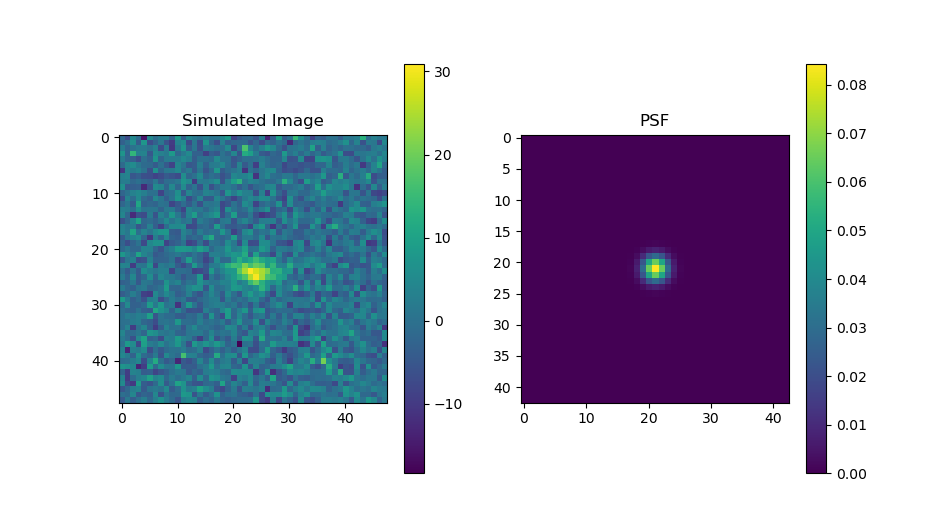

In [39]:
im, psf, im_start, im_end, psf_start, psf_end = make_sim_one_cutout(seed=1234, g1=0.5, g2=0.00, 
                                                                    open_meds=m, obj_ind=obj_index, cutout=0)
#super ellitical just for visualization

pl.figure()
pl.subplot(121)
pl.title('Simulated Image')
box_size = int(np.sqrt(im_end-im_start))
pl.imshow(im.reshape(box_size,box_size))
pl.colorbar()

pl.subplot(122)
pl.title('PSF')
psf_box_size = int(np.sqrt(psf_end - psf_start))
pl.imshow(psf.reshape(psf_box_size,psf_box_size))
pl.colorbar()

pl.show()

Ideally the images above should have more or less the same overall S/N, I think

### Now write the entire file

In [ ]:
input_medsname = '/Users/secco/Documents/projects/delve_shear/delve_cs_test/data/TESTBED_DES0954+0252_r4918p01_i_meds-DECADE.fits.fz'
output_medsname = '/Users/secco/Documents/projects/delve_shear/delve_cs_test/data/exponential_sims_test_1.fits.fz'

replace_all_cutouts_by_sims(input_medsname=input_medsname,output_medsname=output_medsname,verbose=True)

Object 0 has 2 cutouts to be replaced


/Users/secco/opt/anaconda3/envs/delve_shear/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/Users/secco/opt/anaconda3/envs/delve_shear/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


Object 1000 has 4 cutouts to be replaced
Object 2000 has 4 cutouts to be replaced
Object 3000 has 4 cutouts to be replaced
Object 4000 has 4 cutouts to be replaced
Object 5000 has 4 cutouts to be replaced
Object 6000 has 3 cutouts to be replaced
Object 7000 has 3 cutouts to be replaced
Object 8000 has 3 cutouts to be replaced
Object 9000 has 7 cutouts to be replaced
Object 10000 has 8 cutouts to be replaced
Object 11000 has 3 cutouts to be replaced
Object 12000 has 11 cutouts to be replaced
Object 13000 has 8 cutouts to be replaced
Object 14000 has 11 cutouts to be replaced
Object 15000 has 11 cutouts to be replaced
Object 16000 has 8 cutouts to be replaced
Object 17000 has 9 cutouts to be replaced
Object 18000 has 10 cutouts to be replaced
Object 19000 has 9 cutouts to be replaced
Object 20000 has 4 cutouts to be replaced
Object 21000 has 7 cutouts to be replaced
Object 22000 has 7 cutouts to be replaced
Object 23000 has 2 cutouts to be replaced
Object 24000 has 8 cutouts to be replac

By the end of the stuff above, the kernel died and the big PSF row was never written to file...

##### Writing the completed MEDS file to disk wasn't possible neither in my laptop nor midway

In any case, a selection of random cutouts from the real meds file and their simulated counterparts are below: 

<IPython.core.display.Javascript object>


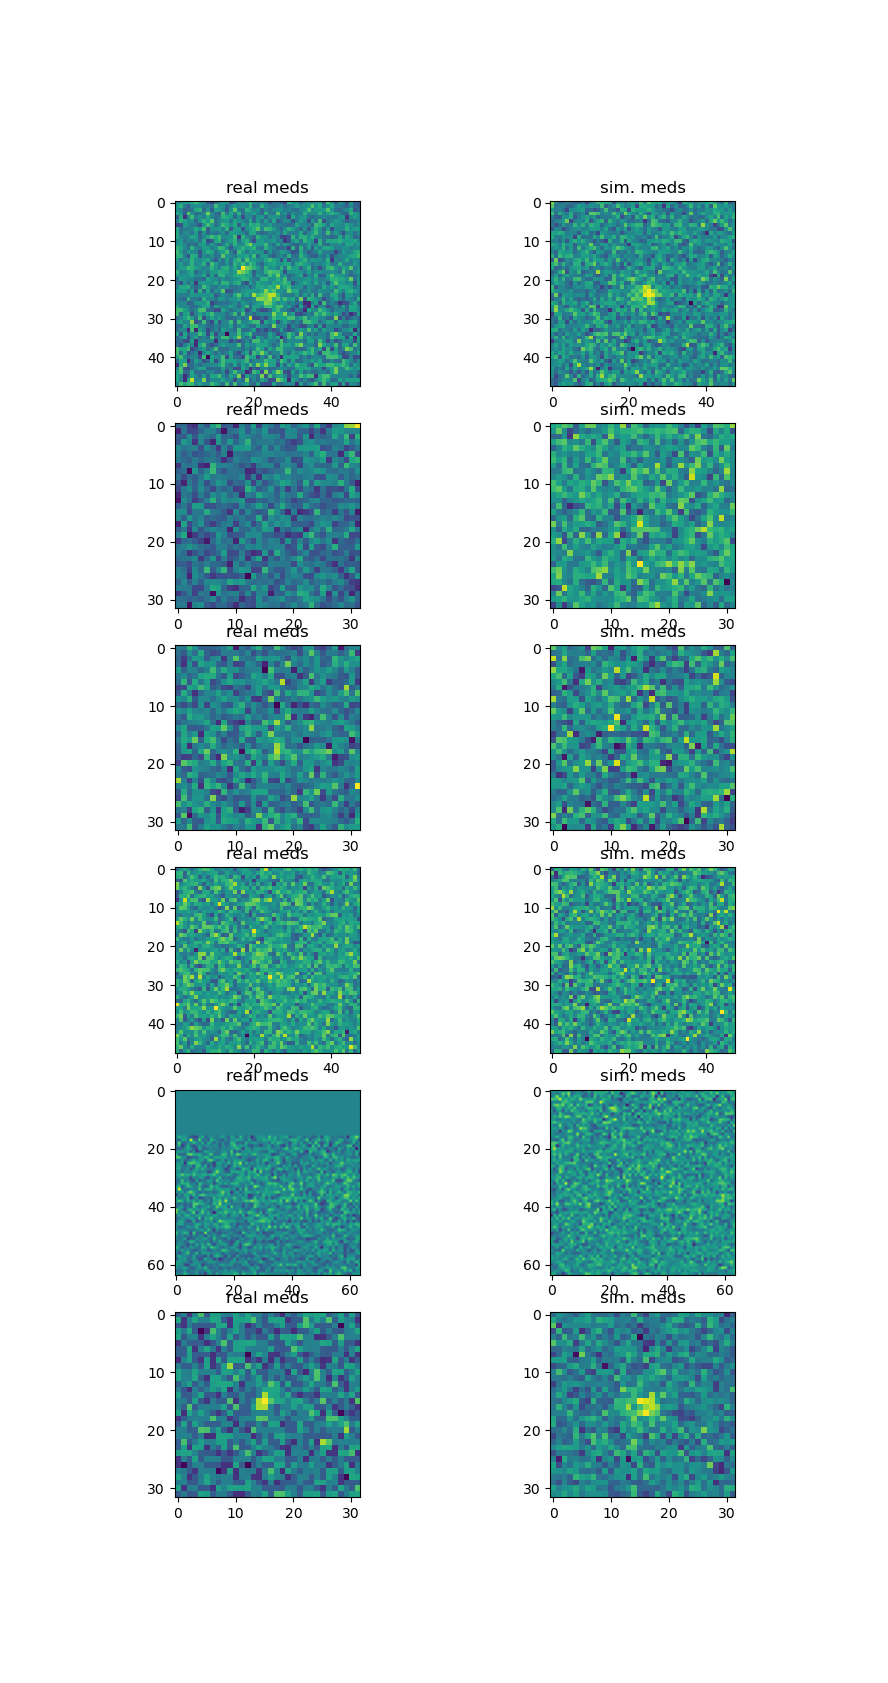

In [40]:
real_meds = fits.open('../data/TESTBED_DES0954+0252_r4918p01_i_meds-DECADE.fits.fz')
simulation_meds = fits.open('../data/exponential_sims_test_1.fits.fz')

pl.figure()

i=1
for obj_index, cutout_index in [(350,0), (420,1), (10900,3), (20010,1), (3,3), (5200,0)]:
    pl.subplot(6,2,i)
    pl.title('real meds')
    start_row = real_meds[1].data['start_row'][obj_index][cutout_index]
    box_size = real_meds[1].data['box_size'][obj_index]
    pl.imshow(real_meds['image_cutouts'].data[start_row:(start_row+box_size**2)].reshape(box_size,box_size))

    pl.subplot(6,2,i+1)
    pl.title('sim. meds')
    start_row = simulation_meds[1].data['start_row'][obj_index][cutout_index]
    box_size = simulation_meds[1].data['box_size'][obj_index]
    pl.imshow(simulation_meds['image_cutouts'].data[start_row:(start_row+box_size**2)].reshape(box_size,box_size))
    
    i=i+2
pl.show()